In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import torch
import os 
from model.SimCLR import SimCLR
from model.Train import Trainer
from model.Losses import NTXentLoss
from utils.DataLoaderSimCLR import DataLoaderSimCLR as DSC
from utils.DataLoaderTest import DataLoaderTest as DLT
from torch.utils.data import DataLoader, random_split
from utils.Similarity import Similarity as SMY
from utils.Plotter import Plotter as PL

In [ ]:
torch.cuda.empty_cache()

In [ ]:
SSH = os.getcwd() != 'c:\\Cours-Sorbonne\\M1\\Stage\\src'

In [ ]:
path_rol_comp = "C:/Cours-Sorbonne/M1/Stage/src/data/rol_compressed" 
path_rol_super_comp = "C:/Cours-Sorbonne/M1/Stage/src/data/rol_super_compressed" 
path_rol_ht_super_comp = "C:/Cours-Sorbonne/M1/Stage/src/data/rol_ht_super_compressed" 
path_sim_rol_extracted_comp = "C:/Cours-Sorbonne/M1/Stage/src/data/similaires_rol_extracted_nn_compressed" 
path_filtered = "C:/Cours-Sorbonne/M1/Stage/src/data/rol_compressed/json_filtered"
path_targets = "C:/Cours-Sorbonne/M1/Stage/src/data/rol_sim_rol_triplets/targets.npy"
bad_pairs_path = "C:/Cours-Sorbonne/M1/Stage/src/files/bad_pairs.txt", 
to_enhance_path = "C:/Cours-Sorbonne/M1/Stage/src/files/to_enhance_pairs.txt",
path_sim_rol_test = "C:/Cours-Sorbonne/M1/Stage/src/data/data_PPTI/sim_rol_test"

if SSH:
    path_rol_ht_super_comp = "../data/rol_ht_super_compressed" 
    path_rol_comp = "../data/rol_super_compressed" 
    path_sim_rol_extracted_comp = "../data/sim_rol_super_compressed" 
    path_filtered = "../data/rol_super_compressed/json_filtered"
    path_sim_rol_test = "../data/sim_rol_test"
    path_targets = "../data/rol_sim_rol_couples/targets.npy"
    bad_pairs_path = "./files/bad_pairs.txt"
    to_enhance_path = "./files/to_enhance_pairs.txt"

## Params

In [ ]:
epochs = 50
image_size = 256
batch_size = 32
learning_rate = 1e-3
train_ratio = 0.8
val_ratio = 0.2
temperature = 0.5

In [ ]:
dataset = DSC(
    path_rol_comp, path_sim_rol_extracted_comp, path_filtered, 
    shape=(image_size, image_size), target_path=path_targets, 
    remove_bad_pairs=True, remove_to_enhance_files=True, 
    augment_test=False, use_only_rol=True, use_context=False, max_images=10000
)

train_size = int(train_ratio * len(dataset))
val_size = len(dataset) - train_size

train_set, val_set = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=2, shuffle=True)
val_loader = DataLoader(val_set, batch_size=2, shuffle=True)

In [ ]:
DSC.show_data(train_loader,2,use_context=False)
DSC.show_data(val_loader,2,use_context=False)

# Approche Supervisé

In [ ]:
model = SimCLR(feature_size=128)
optimizer = torch.optim.AdamW
loss_fn = NTXentLoss(temperature=temperature)

In [ ]:
trainer = Trainer()
trainer.set_model(model, "SimCLR-128") \
.set_optimizer(optimizer) \
.set_loss(loss_fn) 

model = trainer.fit(
    train_data=train_loader, validation_data=val_loader, learning_rate=learning_rate, 
    verbose=True, epochs=epochs, sim_clr=True, use_context=True
)

In [ ]:
trainer.save("model_simclr.pth","history_simclr.txt")

## Testing

In [56]:
testset = DLT(path_sim_rol_test, augment=False)

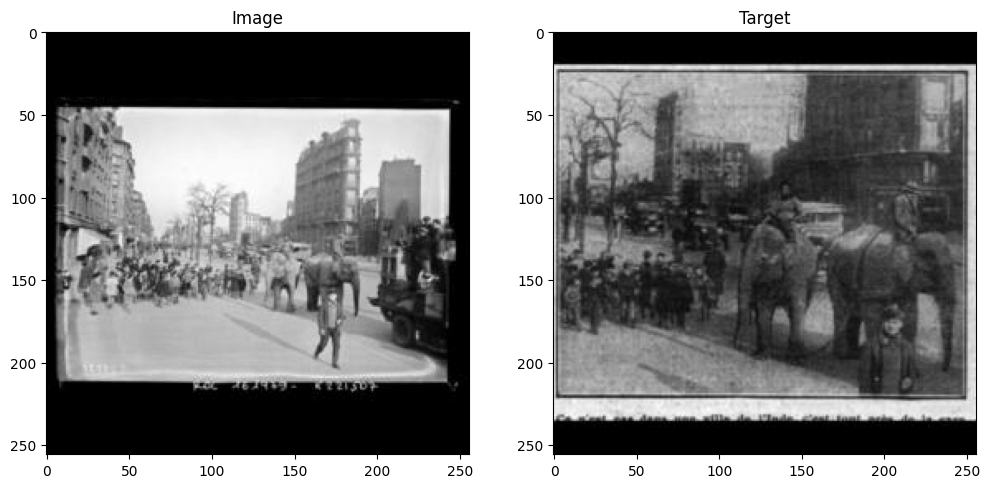

In [58]:
test_loader = DataLoader(testset, batch_size=32, shuffle=True)
DSC.show_data(test_loader, 1, use_context=True)

In [59]:
model = SimCLR(feature_size=128)
model_state = Trainer().get_model("C:/Cours-Sorbonne/M1/Stage/src/params/model/model_simclr_half_RG.pth")
model.load_state_dict(model_state)
history = Trainer().get_history("C:/Cours-Sorbonne/M1/Stage/src/params/model/history_simclr_half_RG.txt")

In [61]:
top_k_pairs, original_images, augmented_images = SMY.match_images_with_simCLR(model, test_loader=test_loader, use_context=False, k=20, use_sift=False, is_test=True)

[INFO] Matching on cuda


100%|██████████| 7/7 [00:01<00:00,  3.98it/s]

[INFO] Top-1 Precision: 0.36363636363636365
[INFO] Top-5 Precision: 0.6161616161616161
[INFO] Top-10 Precision: 0.702020202020202
[INFO] Top-15 Precision: 0.7424242424242424
[INFO] Top-20 Precision: 0.7777777777777778


In [ ]:
best_pairs = top_k_pairs[:,0]
PL.plot_best_pairs(best_pairs, original_images, augmented_images, max_images=10)